In [1]:
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import transforms
from scipy import optimize
from scipy import stats
import GeometryFunctions as gf
import GeneralLattice as gl
import LAMMPSTool as LT 

In [2]:
objdct = dict()
intSigma = 7
strRoot = 'Sigma' + str(intSigma)+ '/Expand/'
for j in os.listdir(strRoot):
    if j.endswith('.dmp'):
        objData = LT.LAMMPSData(strRoot+ str(j),1,4.05, LT.LAMMPSGlobal)
        objHex = objData.GetTimeStepByIndex(-1)
        objdct[j] = objHex
#print(objHex.GetExteriorGrainAtomIDs(1))

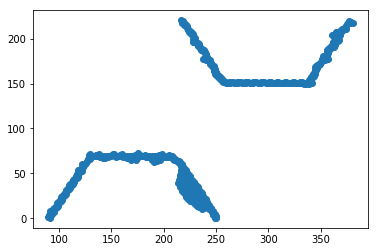

In [10]:
plt.scatter(*tuple(zip(*objHex.GetAtomsByID(objHex.GetExteriorGrainAtomIDs(3))[:,1:3])))

In [ ]:
print(objHex.GetColumnNames())
lstLengths = []
lstTotalEnergy = []
lstExcessStrain =[]
lstLatticeAtoms = []
lstVStrain = []
for k in objdct.keys():
    lstLengths.append(np.linalg.norm(objdct[k].GetCellVectors()[0]))
    lstLatticeAtoms = objdct[k].GetLatticetomIDs()
    lstExcessStrain.append((np.median(objdct[k].GetAtomsByID(lstLatticeAtoms)[:,7])+3.36)*len(lstLatticeAtoms))
    lstVStrain.append(np.median(objdct[k].GetAtomsByID(lstLatticeAtoms)[:,10]))
    #fltMean = np.mean(objdct[k].GetAtomsByID(lstLatticeAtoms)[:,7])
    arrVals = stats.gamma.fit(objdct[k].GetPTMAtoms()[:,7])
    fltMean = arrVals[1]
    lstTotalEnergy.append(np.sum(objdct[k].GetColumnByName('c_pe1')) -fltMean*objdct[k].GetNumberOfAtoms())

In [ ]:
arrVals = stats.gamma.fit(objdct[k].GetPTMAtoms()[:,7])
print(arrVals, arrVals[1]+arrVals[2])
plt.hist(objdct[k].GetPTMAtoms()[:,7],200)
plt.hist(objdct[k].GetNonPTMAtoms()[:,7],200)
plt.ylim([0,500])
print(np.median(objdct[k].GetPTMAtoms()[:,7]), np.mean(objdct[k].GetPTMAtoms()[:,7]))

In [ ]:
print(lstExcessStrain)

In [ ]:
def DirectProportion(l,a1):
    return a1*l
def LinearFit(l,a0,a1):
    return a0+a1*l
def CubicFit(l,a2,a1, a0):
    return a2*l**2 + a1*l +a0*np.log(l)
arr =np.argsort(lstLengths).astype('int')
arrLengths = np.array(lstLengths)[arr]
arrStrain = np.array(lstExcessStrain)[arr]
arrTotal = np.array(lstTotalEnergy)[arr]
arrVStrain = np.array(lstVStrain)[arr]
#plt.scatter(arrLengths,arrTotal)
#plt.ylim([-0.005,0.001])
plt.scatter(arrLengths, arrStrain)
popt2, popv2 = optimize.curve_fit(LinearFit, arrLengths, arrStrain)
arrFitted = LinearFit(arrLengths, *popt2)
plt.plot(arrLengths,arrFitted)
print(popt2)

In [ ]:
print(arrFitted,popt2)

In [ ]:
###### print(arrFitted,popt2)

In [ ]:

popt, popv = optimize.curve_fit(LinearFit, lstLengths, lstTotalEnergy)
print(popt)
arrFitted = LinearFit(np.array(arrLengths), *popt)
arrC = np.polynomial.legendre.legfit(lstLengths, lstTotalEnergy,2)
np.polynomial.legendre.leg2poly(arrC)

In [ ]:
plt.scatter(lstLengths, lstTotalEnergy)
plt.plot(arrLengths, arrFitted, c='r')
plt.xlabel('Simulation Cell Side Length in $\AA$')
plt.ylabel('Total Potential Energy in $eV$')
plt.title('Simulation Cells Consisting of Sigma ' + str(intSigma) + ' CSL Units')
plt.show()

In [ ]:
objData = LT.LAMMPSData('/home/paul/PythonLAMMPS/Hex222Sigma7.dmp',1,4.05, LT.LAMMPSGlobal)
objHex = objData.GetTimeStepByIndex(-1)
fltDatum = np.mean(objHex.GetColumnByName('c_pe1'))
print(fltDatum)

In [ ]:
intSigma = 7
objdct= dict()
#strDirectory = '/home/paul/csf3_scratch/Sigma' + str(intSigma) + '/'
strDirectory = '/home/paul/PythonLAMMPS/'
lstHexNames = ['122','133','233', '123','222' ]
for j in lstHexNames:
    strFile = strDirectory + 'Hex' + str(j) + 'Sigma' + str(intSigma) + '.dmp'
    objData = LT.LAMMPSData(strFile,1,4.05, LT.LAMMPSGlobal)
    objHex = objData.GetTimeStepByIndex(-1)
   # objHex.ReadInDefectData(strFile[:-3] + 'dfc')
    objdct[j] = objHex

In [ ]:
print(objdct['123'].GetColumnNames())
np.sum(objdct['233'].GetAtomsByID(objdct['233'].GetLatticeAtomIDs())[:,7]) +3.360000236*len(objdct['233'].GetLatticeAtomIDs())

In [ ]:
def ExcessEnergies(objHex, lstGBs, lstTJs, lstGN, fltDatum = 3.360000023):
    fltGB = 0
    fltTJ = 0
    fltGN = 0
    for i in lstGBs:
        fltGB += objHex.GetGrainBoundary(i).GetTotalPE() + fltDatum*objHex.GetGrainBoundary(i).GetNumberOfAtoms()
    for j in lstTJs:
        fltTJ += objHex.GetJunctionLine(j).GetTotalPE() + fltDatum*objHex.GetJunctionLine(j).GetNumberOfAtoms()
    for k in lstGN:
        fltGN += np.sum(objHex.GetAtomsByID(objHex.GetGrainAtomIDs(k))[:,7]) + fltDatum*len(objHex.GetGrainAtomIDs(k))
    return [fltGB, fltTJ, fltGN]

In [ ]:
def GetTotalAtoms(objHex, intGrainNumber):
    intNumberOfAtoms = 0
    intNumberOfAtoms = len(objHex.GetGrainAtomIDs(intGrainNumber))
    for j in objHex.GetGrainBoundaryIDs():
        if intGrainNumber in objHex.GetGrainBoundary(j).GetAdjacentGrains():
            intNumberOfAtoms += objHex.GetGrainBoundary(j).GetNumberOfAtoms()
    for k in objHex.GetJunctionLineIDs():
        if intGrainNumber in objHex.GetJunctionLine(k).GetAdjacentGrains():
            intNumberOfAtoms += objHex.GetJunctionLine(k).GetNumberOfAtoms()
    return intNumberOfAtoms

In [ ]:
flt123 = np.sum(lst123)
flt122 = GetTotalAtoms(objHex123,2)*np.sum(lst122)/GetTotalAtoms(objHex122,2)
flt133 = GetTotalAtoms(objHex123,2)*np.sum(lst133)/GetTotalAtoms(objHex133,2)
flt233 = GetTotalAtoms(objHex123,2)*np.sum(lst233)/GetTotalAtoms(objHex233,2)
print(flt123-0.5*(flt122+flt133+flt233))

In [ ]:
fltTotalPE123 = np.sum(objdct['123'].GetAtomData()[:,7])
fltMinusOff = 0
for j in lstHexNames[1:]:
    fltMinusOff += 0.5*objdct['123'].GetNumberOfAtoms()*np.mean(objdct[j].GetAtomData()[:,7])
fltTotalPE123-fltMinusOff-0.5*fltDatum*objdct['123'].GetNumberOfAtoms()

In [ ]:
np.std(objdct['133'].GetAtomsByID(objdct['133'].GetLatticeAtomIDs())[:,7])

In [ ]:
print(lstHexNames)
for j in lstHexNames:
    print(objdct[j].GetNumberOfAtoms())
GetExcessEnergy(objdct['123'], fltDatum)

In [ ]:
def GetExcessEnergy(objGlobal, fltdatum):
    fltTotalPE = np.sum(objGlobal.GetAtomData()[:,7])
    fltExcess = fltTotalPE -fltdatum*objGlobal.GetNumberOfAtoms()
    return fltExcess/objGlobal.GetNumberOfAtoms()

In [ ]:
fltPerAtom =GetExcessEnergy(objdct['123'],fltDatum)-0.5*(GetExcessEnergy(objdct['122'],fltDatum)
                                             +GetExcessEnergy(objdct['133'],fltDatum)
                                             + GetExcessEnergy(objdct['233'],fltDatum))
print(fltPerAtom)

In [ ]:
GetExcessEnergy(objHex123,-3.36)-0.5*(GetExcessEnergy(objHex122, -3.36)+GetExcessEnergy(objHex133, -3.36)+(intAtoms123/intAtoms233)*GetExcessEnergy(objHex233, -3.36))

In [ ]:
(np.mean(objHex133.GetAtomsByID(objHex133.GetLatticeAtomIDs())[:,7])+3.36000002)*len(objHex133.GetLatticeAtomIDs())